## Cargamos las bibliotecas que vamos a usar

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Procesamos las referencias bibliográfica que vamos a usar
Los datos que vamos a usar vienen en formato BibTeX, que es un formato de texto plano con extensión .bib. La biblioteca `bibtexparser` cargada anteriormente nos permite leer y escribir este formato.

La función definida a continuación espera la ubicación de un fichero .bib y devuelve una lista de diccionarios con los datos de las referencias extraídas de ese fichero.

In [4]:
import os
import bibtexparser

def parse_bibtex(file_path):
    """Procesamos un fichero .bib y devolvemos una lista de registros."""
    with open(file_path, 'r') as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
    records = []
    for entry in bib_database.entries:
        records.append({
            'title': entry.get('title', ''),
            'abstract': entry.get('abstract', ''),
            'keywords': entry.get('keywords', '').split(', '),
            'journal': entry.get('journal', '')
        })
    return records

## Cargamos los datos de entrenamiento

Usando la función definida anteriormente, cargamos todos los datos del directorio de entrenamiento y los vamos procesando uno a uno. Al finalizar, obtenemos un dataframe que usaremos para entrenar el modelo.

In [5]:
import pandas as pd

def load_data_from_directory(directory_path):
    """Cargamos todos los ficheros .bib de un directorio y sus subdirectorios."""
    all_records = []
    for journal_folder in os.listdir(directory_path):
        folder_path = os.path.join(directory_path, journal_folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.bib'):
                    file_path = os.path.join(folder_path, file)
                    all_records.extend(parse_bibtex(file_path))
    return pd.DataFrame(all_records)

# Cargamos todos los ficheros usando la función definida anteriormente
data_path = "data/"
df = load_data_from_directory(data_path)

# Guardamos los datos procesados en un nuevo archivo CSV (para evitar tener que volver a procesar los datos)
df.to_csv("processed_data.csv", index=False)

# Mostramos los primeros registros para verificar que todo ha ido bien
print(df.head())

                                               title  \
0  Sociotechnical systems as a framework for regu...   
1  Emotional factors and physical properties of b...   
2  “They say we have a choice, but we don't”: A g...   
3  Measuring and improving adaptive capacity in r...   
4  Comfortable leg splay of mid-sized males in au...   

                                            abstract  \
0  Like most work systems, the domain of adventur...   
1  Many studies of ballpoint pens have been condu...   
2  For parents working in the transportation indu...   
3  Resilient systems strive to enhance the safety...   
4  Many factors affect the comfort of automotive ...   

                                            keywords             journal  
0  [Adventure activities, Adventure education, Co...  Applied Ergonomics  
1  [Ballpoint pens, Styluses, Emotion, House of q...  Applied Ergonomics  
2  [Atypical schedules, Ergonomic intervention, W...  Applied Ergonomics  
3  [Resilience engineering

## Preprocesamiento de los datos
Antes de entrenar el modelo de recomendación, es necesario preprocesar los datos. Esto incluye la limpieza de los datos, la eliminación de valores atípicos y la normalización de los datos.

- Quitamos todo lo que no sea texto
- Pasamos todo el texto a minúsculas
- Quitamos los signos de puntuación
- Quitamos los números #FIXME realmente hace falta?
- Tokenizamos el texto (Lo separamos en palabras)
- Para cada palabra, eliminamos las stopwords (palabras que no aportan información) y lematizamos (convertimos las palabras a su forma base)


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Definimos stopwords para inglés y instanciamos el lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Normalizar y preprocesar el texto.."""
    # Quitamos todo lo que no sean letras
    if not isinstance(text, str):
        return ""
    
    # Pasamos el texto a minúsculas
    text = text.lower()
    
    # Quitamos puntos, comas y otros caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenizamos el texto
    tokens = word_tokenize(text)
    
    # Quitamos las stopwords y aplicamos lematización
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Volvemos a unir las palabras en una sola cadena
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to /home/rtorrero/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rtorrero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rtorrero/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Aplicamos las reglas de preprocesador del texto:

In [7]:
# Esto permite cargar el dataframe desde el archivo CSV, en caso de querer evitar repetir el proceso de preprocesamiento
if 'df' not in locals():
    df = pd.read_csv("processed_data.csv")

# Aplicamos el preprocesamiento
df['title_cleaned'] = df['title'].apply(preprocess_text)
df['abstract_cleaned'] = df['abstract'].apply(preprocess_text)

# Volvemos a guardar el DataFrame en un nuevo archivo CSV
df.to_csv("cleaned_data.csv", index=False)

# Mostramos una previsualizzación de los datos procesados
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())


                                               title  \
0  Sociotechnical systems as a framework for regu...   
1  Emotional factors and physical properties of b...   
2  “They say we have a choice, but we don't”: A g...   
3  Measuring and improving adaptive capacity in r...   
4  Comfortable leg splay of mid-sized males in au...   

                                       title_cleaned  \
0  sociotechnical system framework regulatory sys...   
1  emotional factor physical property ballpoint p...   
2  say choice dont gendered reflection workfamily...   
3  measuring improving adaptive capacity resilien...   
4  comfortable leg splay midsized male automotive...   

                                            abstract  \
0  Like most work systems, the domain of adventur...   
1  Many studies of ballpoint pens have been condu...   
2  For parents working in the transportation indu...   
3  Resilient systems strive to enhance the safety...   
4  Many factors affect the comfort of automoti

## Modelos para el clasificador
A continuación, planteamos una serie de modelos para el clasificador de revistas. 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Configuraciones
n_features_options = [250, 500, 1000]
vectorizers = {
    'TF-IDF': TfidfVectorizer,
    'TF': CountVectorizer,
}
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=26),
    'Random Forest (200)': RandomForestClassifier(n_estimators=200, random_state=26),
    'Naive Bayes Classifier': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=26),
    'KNN': KNeighborsClassifier(n_neighbors=5),
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=26)


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluación de modelos
def evaluar_modelos(vectorizers, models, n_features_options, X_clean, y, skf):
    resultados = []
    for vec_name, vec_class in vectorizers.items():
        for n_features in n_features_options:
            vectorizer = vec_class(max_features=n_features)
            X_vectorized = vectorizer.fit_transform(X_clean)

            # Ahora, iteramos sobre los modelos
            for model_name, model in models.items():
                print(f"Evaluando modelo: {model_name} con {vec_name} y {n_features} features")
                # fold_accuracies = []
                # Perform k-fold cross validation
                metrics = {
                    'accuracy': [],
                    'precision': [],
                    'recall': [],
                    'f1': []
                }
                for train_idx, test_idx in skf.split(X_vectorized, y):
                    X_train, X_test = X_vectorized[train_idx], X_vectorized[test_idx]
                    y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]

                    # Entrenamos el modelo
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                    #fold_accuracies.append(accuracy_score(y_test, y_pred))
                    # Calculate metrics
                    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                    metrics['precision'].append(precision_score(y_test, y_pred, average='weighted'))
                    metrics['recall'].append(recall_score(y_test, y_pred, average='weighted'))
                    metrics['f1'].append(f1_score(y_test, y_pred, average='weighted'))

                resultados.append({
                    'Vectorizador': vec_name,
                    'Núm. Características': n_features,
                    'Modelo': model_name,
                    'Exactitud media': np.mean(metrics['accuracy']),
                    'Precisión media': np.mean(metrics['precision']),
                    'Recall medio': np.mean(metrics['recall']),
                    'F1-score medio': np.mean(metrics['f1']),
                    'Desviación estándar de la exactitud': np.std(metrics['accuracy']),
                })
                
    return pd.DataFrame(resultados)

In [26]:
# Evaluar modelos
df['combined_text'] = df['title_cleaned'] + " " + df['abstract_cleaned']
X_clean = df['combined_text']
y = df['journal']

results_df = evaluar_modelos(vectorizers, models, n_features_options, X_clean, y, skf)

Evaluando modelo: Logistic Regression con TF-IDF y 250 features
Evaluando modelo: Random Forest (200) con TF-IDF y 250 features
Evaluando modelo: Naive Bayes Classifier con TF-IDF y 250 features
Evaluando modelo: Gradient Boosting con TF-IDF y 250 features
Evaluando modelo: KNN con TF-IDF y 250 features
Evaluando modelo: Logistic Regression con TF-IDF y 500 features
Evaluando modelo: Random Forest (200) con TF-IDF y 500 features
Evaluando modelo: Naive Bayes Classifier con TF-IDF y 500 features
Evaluando modelo: Gradient Boosting con TF-IDF y 500 features
Evaluando modelo: KNN con TF-IDF y 500 features
Evaluando modelo: Logistic Regression con TF-IDF y 1000 features
Evaluando modelo: Random Forest (200) con TF-IDF y 1000 features
Evaluando modelo: Naive Bayes Classifier con TF-IDF y 1000 features
Evaluando modelo: Gradient Boosting con TF-IDF y 1000 features
Evaluando modelo: KNN con TF-IDF y 1000 features
Evaluando modelo: Logistic Regression con TF y 250 features
Evaluando modelo: Ra

Top 5 Model Configurations:
                    Modelo Vectorizador  Núm. Características  \
10     Logistic Regression       TF-IDF                  1000   
26     Random Forest (200)           TF                  1000   
12  Naive Bayes Classifier       TF-IDF                  1000   
5      Logistic Regression       TF-IDF                   500   
11     Random Forest (200)       TF-IDF                  1000   

    Exactitud media  Precisión media  F1-score medio  \
10         0.821422         0.820048        0.819356   
26         0.810670         0.813581        0.803900   
12         0.809612         0.808255        0.805678   
5          0.804767         0.808475        0.805349   
11         0.807085         0.807998        0.801419   

    Desviación estándar de la exactitud  composite_score  
10                             0.004214         0.819547  
26                             0.005558         0.808401  
12                             0.010759         0.805873  
5       

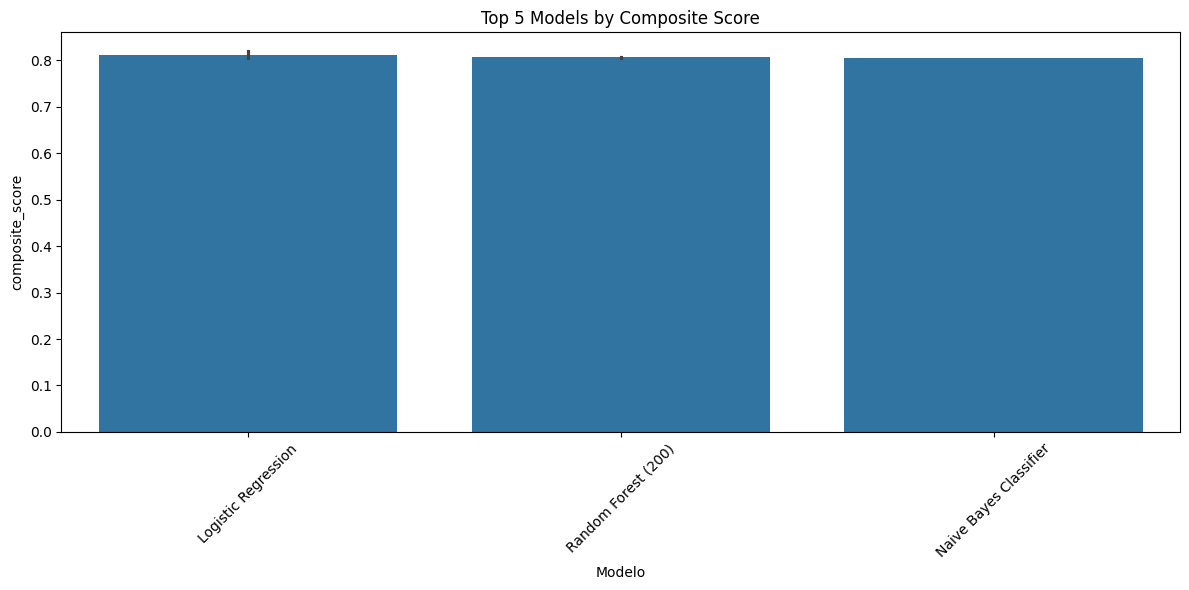

In [32]:
# Calculate a composite score combining all metrics
results_df['composite_score'] = (
    results_df['Exactitud media'] * 0.3 +
    results_df['Precisión media'] * 0.3 +
    results_df['F1-score medio'] * 0.3 +
    results_df['Recall medio'] * 0.1 -
    results_df['Desviación estándar de la exactitud'] * 0.2  # Penalize high variance
)

# Sort by composite score and display top models
ranked_results = results_df.sort_values(by='composite_score', ascending=False)

# Display detailed performance breakdown
print("Top 5 Model Configurations:")
print(ranked_results[['Modelo', 'Vectorizador', 'Núm. Características', 'Exactitud media', 'Precisión media', 'F1-score medio', 'Desviación estándar de la exactitud', 'composite_score']].head())

# Create visualization of top models performance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=ranked_results.head(5), x='Modelo', y='composite_score')
plt.xticks(rotation=45)
plt.title('Top 5 Models by Composite Score')
plt.tight_layout()
plt.show()

In [ ]:
# Selección del best_model basado en el top accuracy
best_result = results_df.iloc[0]  # Seleccionar la fila con el mejor accuracy
best_model_config = {
    'Vectorizer': best_result['Vectorizer'],
    'n_features': best_result['n_features'],
    'Model': best_result['Model'],
}

# Guardamos el mejor modelo


print(f"\nMejor configuración encontrada: {best_model_config}")

In [ ]:
import joblib
from preprocess import preprocess_text

# Load the vectorizer and model
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
model = joblib.load("journal_recommendation_model.pkl")

def recommend_journal(title, abstract):
    """Recommend a journal based on title and abstract."""
    combined_text = title + " " + abstract
    combined_text_cleaned = preprocess_text(combined_text)  # Reuse your preprocess_text function
    X_input = tfidf_vectorizer.transform([combined_text_cleaned])
    return model.predict(X_input)[0]

# Example usage
title = "Design, control and evaluation of a treadmill-based Pelvic Exoskeleton (PeXo) with self-paced walking mode"
abstract = "Most gait rehabilitation exoskeletons focus only on assisting lower limb motions. However, the pelvis plays an essential role in overground ambulation. This calls for the need of gait training devices that allow full control and assistance of user’s pelvis to improve gait rehabilitation therapies of stroke survivors. This paper presents a new pelvic assistance treadmill-based exoskeleton (PeXo) for gait rehabilitation. The system includes a total of 5 actively controlled Degrees of Freedom (DOFs), plus a passive one, in order to provide all DOFs of the human pelvis. The paper describes the mechatronic design and haptic control of PeXo, and introduces a newly developed self-paced walking mode where the user can control walking speed at his/her will. The system was evaluated by means of a pilot study with a stroke survivor. Results showed PeXo can be used safely and reliably during walking activities, allowing for the natural motion of the pelvis with reduced interaction forces. However, the use of the platform reduced user’s Range of Motion at the pelvis and lower limb joints, whereas lower limb’s muscle activity increased to compensate the disturbances introduced by the platform. Nevertheless, the user reported a positive feedback when using the system, suggesting potential and promising advantages of PeXo that should be explored in a larger study in the future."
print("Recommended Journal:", recommend_journal(title, abstract))
